<a href="https://colab.research.google.com/github/McHughes288/alignment-jam/blob/main/logit_lens_whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whisper Logit Lens
Seeing if logit lens behaviour is in the encoder and decoder transformers of Whisper.

## Setup

In [2]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/PySvelte.git to /tmp/pip-req-build-sr89_mkv
  Running command git clone -q https://github.com/neelnanda-io/PySvelte.git /tmp/pip-req-build-sr89_mkv
     |████████████████████████████████| 41 kB 447 kB/s 
     |████████████████████████████████| 441 kB 13.2 MB/s 
     |████████████████████████████████| 5.5 MB 67.5 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 68.8 MB/s 
     |████████████████████████████████| 163 kB 71.7 MB/s 
     |████████████████████████████████| 115 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 65.7 MB/s 
     |████████████████████████████████| 115 kB 63.7 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
  Created wheel for PySvelte: filename=PySvelte-1.0.0-py3-none-any.whl size=155018 sha256=ff449446ab04780b6

In [3]:
from collections import defaultdict
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperTokenizer
from datasets import load_dataset
import datasets
import torch
import torch.nn as nn
import copy

In [4]:
# load dummy dataset and read soundfiles
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-medium")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-medium")

num_decoder_layers = len(model.model.decoder.layers)
num_encoder_layers = len(model.model.encoder.layers)
print(num_encoder_layers, num_decoder_layers)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/185k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/830 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/494k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

24 24


## Truncate model

In [106]:
def run_model(model, data):
    input_features = processor(data["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_features 
    # Generate logits
    predicted_ids = model.generate(input_features, decoder_input_ids = torch.tensor([[50258]]), output_attentions=True)
    # take argmax and decode
    transcription_as_list = [processor.decode(p) for p in predicted_ids.flatten()]
    print("".join(transcription_as_list))


In [10]:
print(ds[0]["text"].lower().capitalize())
run_model(model, ds[0])

Mister quilter is the apostle of the middle classes and we are glad to welcome his gospel


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.<|endoftext|>


In [7]:
def truncate_model(model, d_layers_to_remove=0, e_layers_to_remove=0):
  print(f"e_layers_to_remove {e_layers_to_remove}, d_layers_to_remove {d_layers_to_remove}")
  num_e_layers = len(model.model.encoder.layers)
  num_d_layers = len(model.model.decoder.layers)
  model_truncated = copy.deepcopy(model)
  model_truncated.model.encoder.layers = nn.ModuleList(list(model.model.encoder.layers.children()))[:num_e_layers-e_layers_to_remove]
  model_truncated.model.decoder.layers = nn.ModuleList(list(model.model.decoder.layers.children()))[:num_d_layers-d_layers_to_remove]
  return model_truncated

In [ ]:
def truncate_model(model, d_layers_to_remove=0):
  num_d_layers = len(model.model.decoder.layers)
  model_truncated = copy.deepcopy(model)
  model_truncated.model.decoder.layers = nn.ModuleList(list(model.model.decoder.layers.children()))[:num_d_layers-d_layers_to_remove]
  return model_truncated

In [44]:
run_stage = False

In [45]:
if run_stage:
  print("Encoder logits lens")
  for i in range(9, 24):
    model_truncated = truncate_model(model, e_layers_to_remove=i)
    run_model(model_truncated, ds[0])

In [46]:
# Encoder logits lens
# e_layers_to_remove 9, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel<|endoftext|>
# e_layers_to_remove 10, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Quillture is the apostle of the middle classes and we are glad to welcome you to the school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of the new school of
# e_layers_to_remove 11, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Kroehl, the owner of the company, is a former owner of the company.<|endoftext|>
# e_layers_to_remove 12, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo
# e_layers_to_remove 13, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo, Mr. Koo
# e_layers_to_remove 14, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> The problem is that the system is not working properly.<|endoftext|>
# e_layers_to_remove 15, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> We're going to use the same method that we used in the previous video.<|endoftext|>
# e_layers_to_remove 16, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|> the word.<|endoftext|>
# e_layers_to_remove 17, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|>,<|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|ur|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|><|tr|>
# e_layers_to_remove 18, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|>
# e_layers_to_remove 19, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|>
# e_layers_to_remove 20, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|ur|><|ur|><|ur|><|ur|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|>
# e_layers_to_remove 21, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|en|><|transcribe|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|en|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|>
# e_layers_to_remove 22, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|><|ml|>
# e_layers_to_remove 23, d_layers_to_remove 0
# <|startoftranscript|><|en|><|transcribe|><|notimestamps|><|ms|><|sv|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|ta|><|ms|><|sv|><|da|><|ms|><|sv|><|da|><|ms|><|ta|><|ms|><|sv|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|><|da|>

In [47]:
if run_stage:
  print("Decoder logits lens")
  for i in range(1, 5):
    model_truncated = truncate_model(model, ds[0], d_layers_to_remove=i)
    run_model(model_truncated, ds[0])

## Output logits

In [5]:
def register_hooks(model):
    # Activation hook to get attention scores
    logits = defaultdict(list)
    def getActivation(name):
        # the hook signature
        def hook(module, input, output):
            logits[name].append(output.detach())
        return hook

    hook = model.proj_out.register_forward_hook(getActivation("proj_out"))
    return hook, logits

def run_model_with_hooks(model, data):
    hook, logits = register_hooks(model)
    input_features = processor(data["audio"]["array"], return_tensors="pt", sampling_rate=16000, return_attention_mask = True).input_features 
    # Generate logits
    predicted_ids = model.generate(input_features, decoder_input_ids = torch.tensor([[50258]]))
    # take argmax and decode
    transcription_as_list = [processor.decode(p) for p in predicted_ids.flatten()]
    hook.remove()
    return "".join(transcription_as_list), logits, predicted_ids

In [93]:
print("Encoder logits lens")
layer_ids = []
layer_logits = []
for i in range(0, 20, 1):
  model_truncated = truncate_model(model, e_layers_to_remove=i)
  text, logits, predicted_ids = run_model_with_hooks(model_truncated, ds[0])
  ids = [logits.argmax().item() for logits in logits["proj_out"]]
  max_logit = [logits.max().item() for logits in logits["proj_out"]]
  layer_ids.append(ids)
  layer_logits.append(max_logit)
  print(ids)
  print(max_logit)
  print(text)
  print("\n")
  assert predicted_ids.squeeze().tolist()[1:] == ids

Encoder logits lens
e_layers_to_remove 0, d_layers_to_remove 0


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[50259, 50359, 50363, 2221, 13, 2326, 388, 391, 307, 264, 50244, 295, 264, 2808, 5359, 293, 321, 366, 5404, 281, 2928, 702, 14943, 13, 50257]
[0.0, 0.0, 0.0, 14.804353713989258, 18.9575252532959, 12.684587478637695, 21.11880874633789, 27.529409408569336, 42.86042022705078, 36.480560302734375, 14.953550338745117, 50.561195373535156, 44.00162124633789, 30.760093688964844, 40.963253021240234, 42.53091049194336, 45.837181091308594, 40.33502197265625, 33.21329116821289, 50.633705139160156, 32.563514709472656, 39.59298324584961, 16.41779327392578, 35.12213897705078, 13.761148452758789]
<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.<|endoftext|>


e_layers_to_remove 1, d_layers_to_remove 0
[50259, 50359, 50363, 2221, 13, 2326, 388, 391, 307, 264, 50244, 295, 264, 2808, 5359, 293, 321, 366, 5404, 281, 2928, 796, 13, 50257]
[0.0, 0.0, 0.0, 12.309489250183105, 22.048736572265625, 13.755229949951172

## Plotting utils

In [94]:
import colorcet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def token_string(tokenizer, tokens):
  subwords = []
  for token in tokens:
    if token == -1:
      subwords.append("")
    else:
      subwords.append(tokenizer.decode(token).strip())
  return subwords

def show_token_progress(logits, tokens, yticks, cell_text_is="tokens", id_to_string=True):

  ny, nx = logits.shape
  if id_to_string:
    tokens = np.array([token_string(tokenizer, t) for t in tokens])

  cmap="cet_" + "linear_protanopic_deuteranopic_kbw_5_98_c40"
  fig, ax = plt.subplots(1, 1, figsize=(1.2*nx, 20))
  im=ax.imshow(logits, vmin=0, vmax=logits.max(), aspect="auto", cmap=cmap, norm=None)

  ax.set_xticks(range(nx))
  ax.set_xticklabels(tokens[0], fontsize=12, rotation=45, horizontalalignment='right',)

  ax_top = ax.secondary_xaxis('top')
  ax_top.set_xticks(range(nx))
  ax_top.set_xticklabels(tokens[0], fontsize=15, rotation=45, horizontalalignment='left',)

  ax.set_yticks(range(ny))
  ax.set_yticklabels(yticks, fontsize=12)

  def _add_patches_for_correctness():
    edgecolor = 'k'
    for i in range(ny):
      for j in range(nx):
        if (tokens[i, j] == tokens[0, j]):
          ax.add_patch(mpl.patches.Rectangle((j-0.5, i-0.5), 1, 1, 
                                            fill=False, snap=True,
                                            edgecolor=edgecolor,
                                            alpha=1,
                                            lw=3,))

  def _visible_text_color(value):
    return 'w' if value<10 else 'k'

  def _add_cell_text():
    for i in range(ny):
      for j in range(nx):
        if cell_text_is=="tokens":
          cell_text = tokens[i, j]
        elif cell_text_is=="values":
          cell_text = logits[i, j]
        
        fontsize = 10
        if cell_text == ".":
          fontsize = 15

        plt.text(j, i, (cell_text),
                  name='sans', c=_visible_text_color(logits[i, j]),
                  horizontalalignment='center',
                  verticalalignment='center', 
                  fontsize=fontsize
                  )

  _add_patches_for_correctness()
    
  _add_cell_text()

  plt.colorbar(im, ax=[ax], pad=0.08, location='top',)
  plt.tick_params(labelsize=12)

  ax.set_facecolor('w')
  ax_top.set_facecolor('w')

## Plot logit lens

In [95]:
from torch.nn.utils.rnn import pad_sequence
max_len = len(layer_ids[0]) +10
tokens = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_ids], batch_first=True, padding_value=-1).numpy()
logits = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_logits], batch_first=True, padding_value=-1).numpy()
print(tokenizer.decode(tokens[0]))

 Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.<|endoftext|>


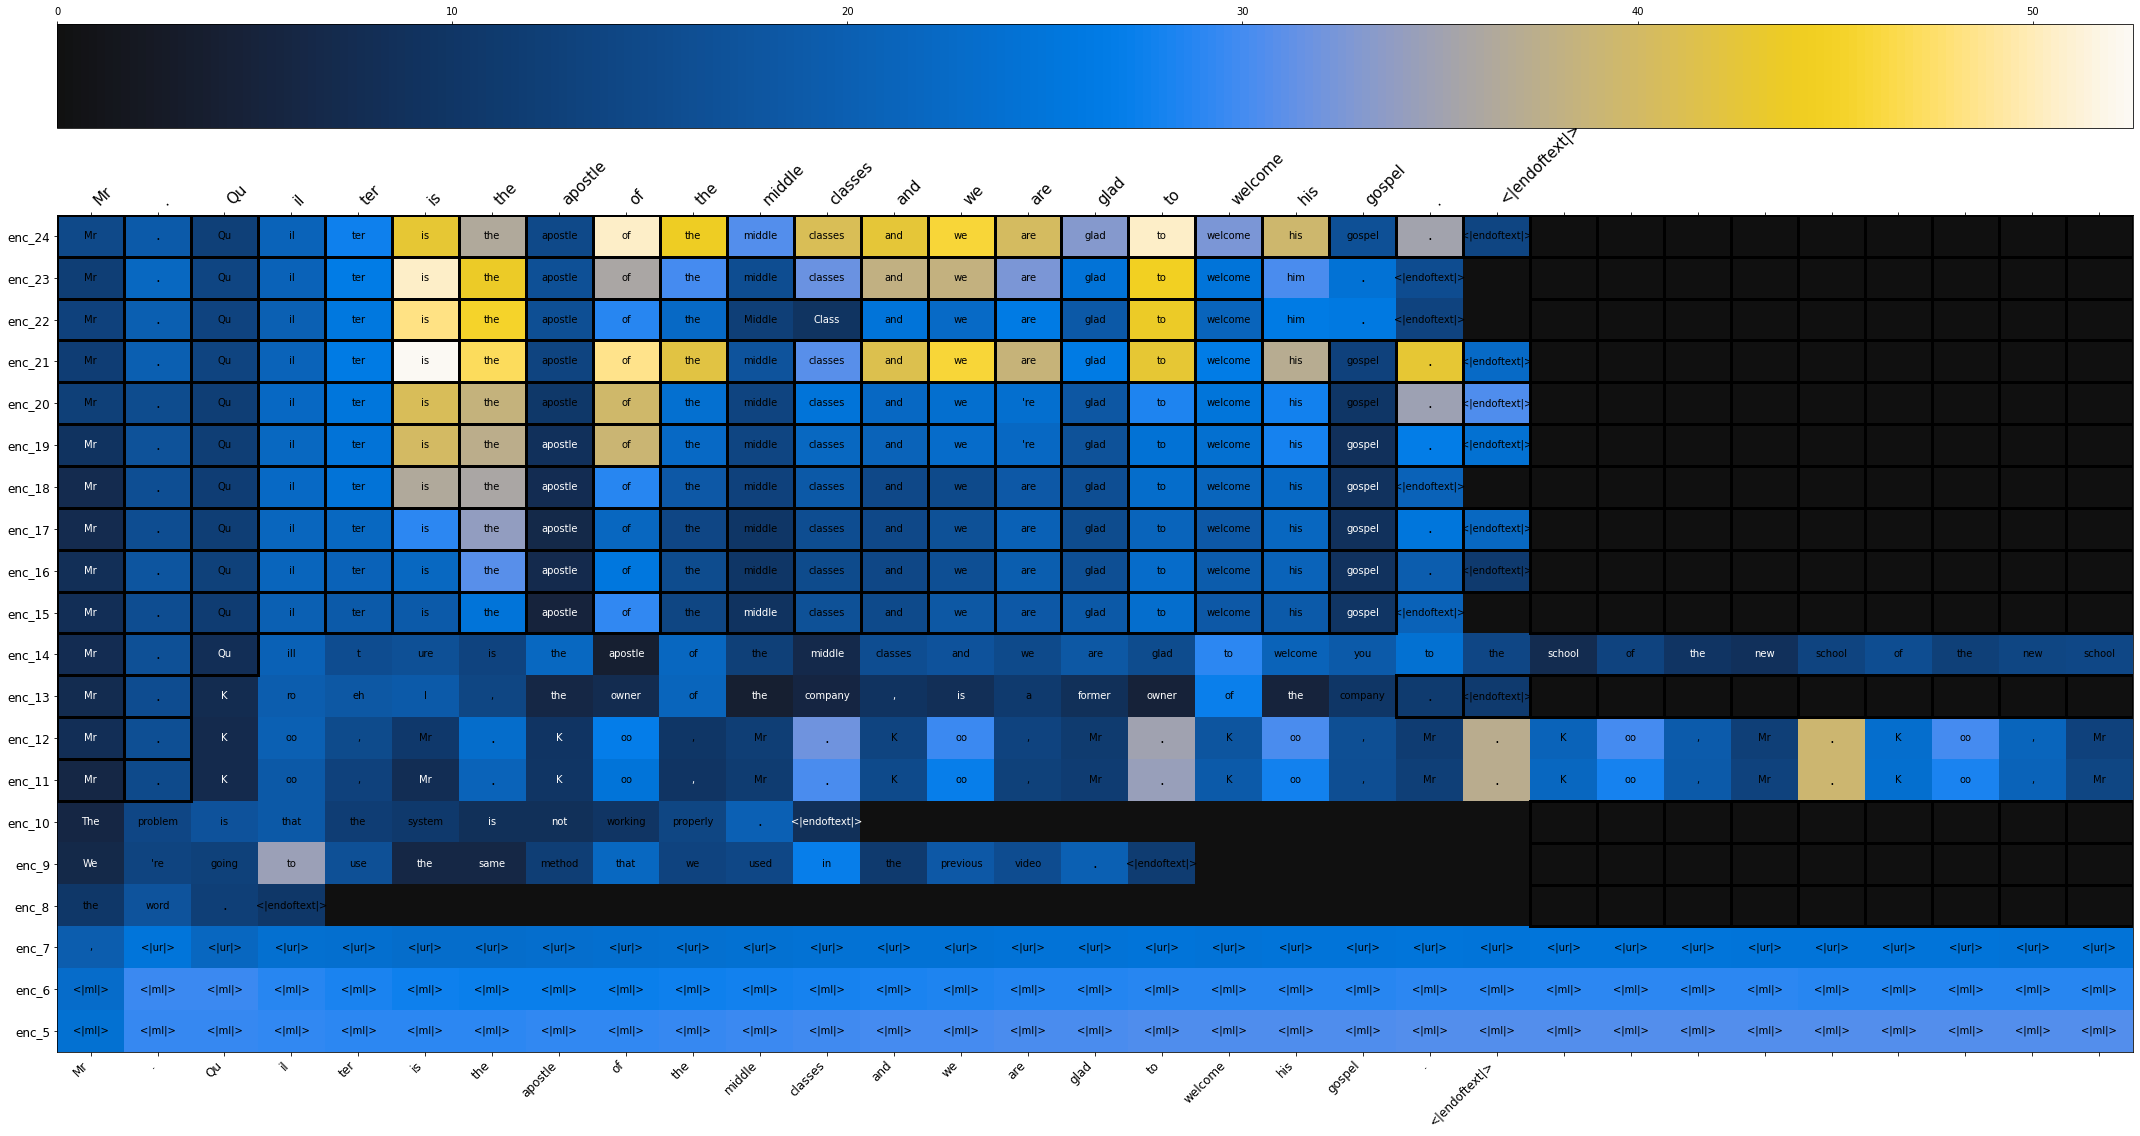

In [97]:
layers = [24 - y for y in list(range(0, 20))]
yticks = [f"enc_{y}" for y in layers]
show_token_progress(logits, tokens, yticks)

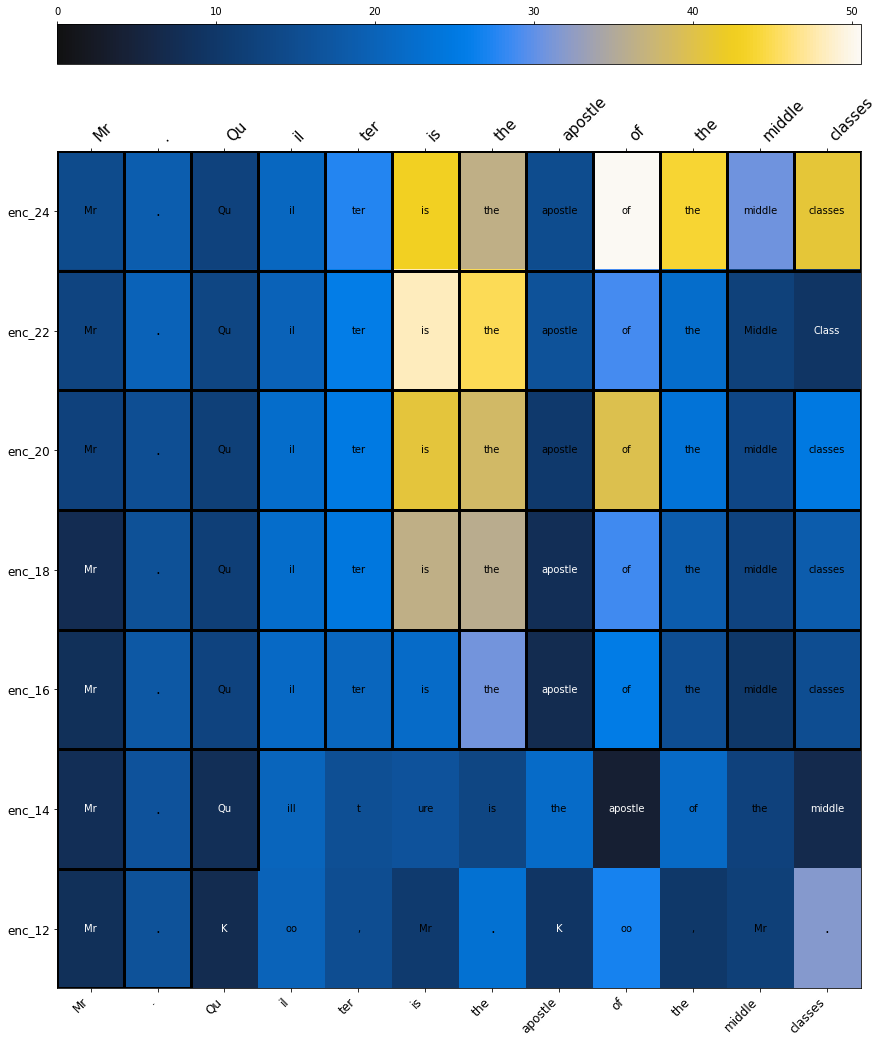

In [106]:
max_len = len(layer_ids[0]) -9
tokens = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_ids[0:14:2]], batch_first=True, padding_value=-1).numpy()
logits = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_logits[0:14:2]], batch_first=True, padding_value=-1).numpy()
layers = [24 - y for y in list(range(0, 14, 2))]
yticks = [f"enc_{y}" for y in layers]
show_token_progress(logits, tokens, yticks)

In [100]:
print("Decoder logits lens")
layer_ids_decoder = []
layer_logits_decoder = []
for i in range(0, 5, 1):
  model_truncated = truncate_model(model, d_layers_to_remove=i)
  text, logits, predicted_ids = run_model_with_hooks(model_truncated, ds[0])
  ids = [logits.argmax().item() for logits in logits["proj_out"]]
  max_logit = [logits.max().item() for logits in logits["proj_out"]]
  layer_ids_decoder.append(ids)
  layer_logits_decoder.append(max_logit)
  print(ids)
  print(max_logit)
  print(text)
  print("\n")
  assert predicted_ids.squeeze().tolist()[1:] == ids

Decoder logits lens
e_layers_to_remove 0, d_layers_to_remove 0


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


[50259, 50359, 50363, 2221, 13, 2326, 388, 391, 307, 264, 50244, 295, 264, 2808, 5359, 293, 321, 366, 5404, 281, 2928, 702, 14943, 13, 50257]
[0.0, 0.0, 0.0, 14.804353713989258, 18.9575252532959, 12.684587478637695, 21.11880874633789, 27.529409408569336, 42.86042022705078, 36.480560302734375, 14.953550338745117, 50.561195373535156, 44.00162124633789, 30.760093688964844, 40.963253021240234, 42.53091049194336, 45.837181091308594, 40.33502197265625, 33.21329116821289, 50.633705139160156, 32.563514709472656, 39.59298324584961, 16.41779327392578, 35.12213897705078, 13.761148452758789]
<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.<|endoftext|>


e_layers_to_remove 0, d_layers_to_remove 1
[50259, 50359, 50363, 2221, 13, 2326, 373, 391, 307, 264, 50244, 295, 264, 2808, 5359, 293, 321, 366, 5404, 281, 2928, 702, 14943, 13, 50257]
[0.0, 0.0, 0.0, 15.346769332885742, 19.282121658325195, 11.38932132

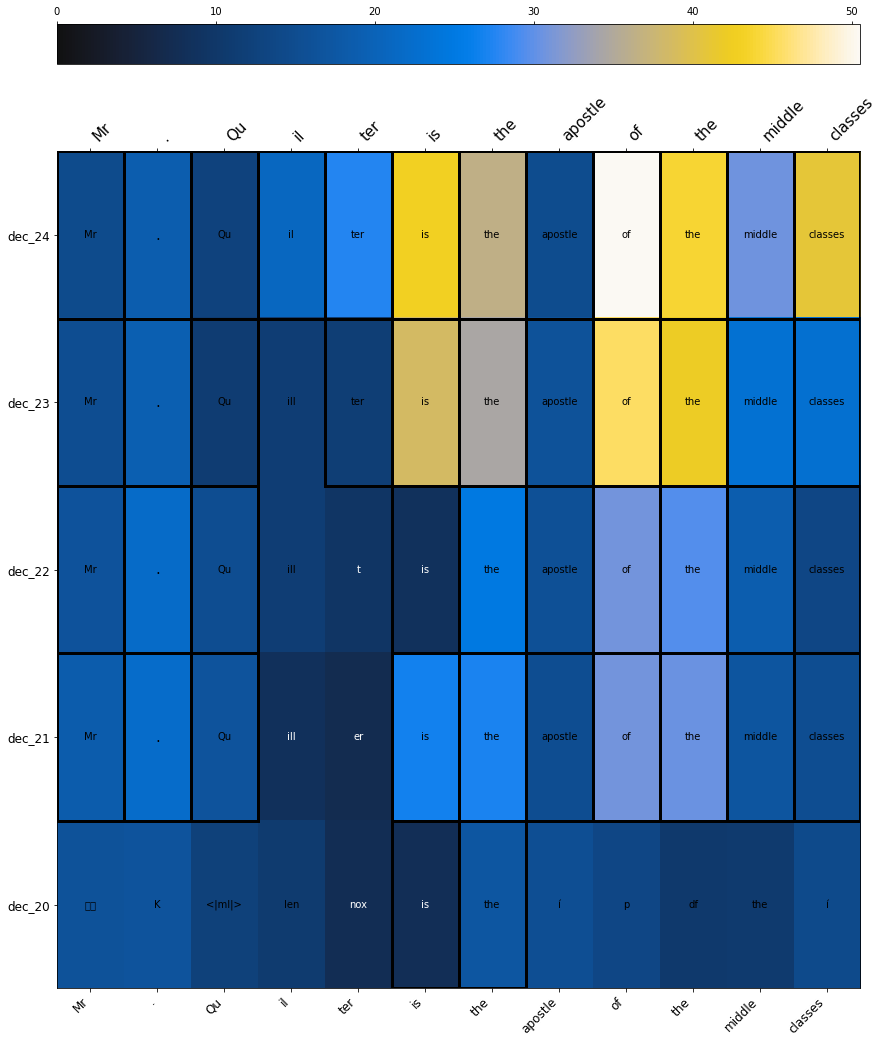

In [107]:
max_len = len(layer_ids_decoder[0]) -9
tokens = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_ids_decoder], batch_first=True, padding_value=-1).numpy()
logits = pad_sequence([torch.tensor(x)[3:max_len-1] for x in layer_logits_decoder], batch_first=True, padding_value=-1).numpy()
layers = [24 - y for y in list(range(0, 5))]
yticks = [f"dec_{y}" for y in layers]
show_token_progress(logits, tokens, yticks)

## WER plots

In [108]:
encoder_layers = [24, 23, 22, 21, 20, 18, 12]
encoder = [3.73, 4.68, 16.62, 15.37, 23.84, 33.17, 103.37]
decoder_layers = [24, 23, 22, 21, 20]
decoder = [3.73, 9.81, 45.66, 75.49, 92.39]

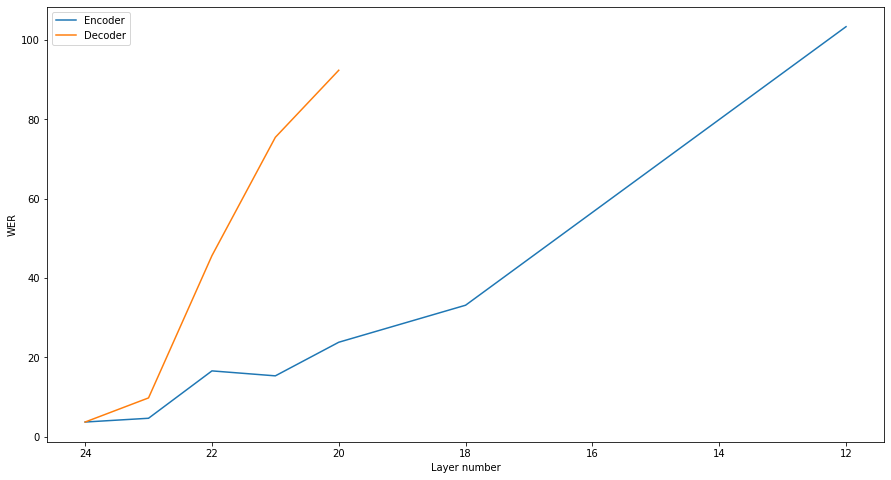

In [109]:
plt.figure(figsize=(15, 8))
plt.plot(encoder_layers, encoder)
plt.plot(decoder_layers, decoder)
plt.xlabel("Layer number")
plt.ylabel("WER")
plt.legend(['Encoder', 'Decoder'])
plt.gca().invert_xaxis()